<a href="https://colab.research.google.com/github/rhiats/pimaDiab/blob/main/pima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

**Load Data**

In [2]:
df=pd.read_csv("/content/drive/MyDrive/assignments/Spring24/Spec Project/diabetes.csv")
df.insert(0, 'ID', range(0, len(df)))
df.head()
df.astype(int)

,ID,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,6,148,72,35,0,33,0,50,1
1,1,1,85,66,29,0,26,0,31,0
2,2,8,183,64,0,0,23,0,32,1
3,3,1,89,66,23,94,28,0,21,0
4,4,0,137,40,35,168,43,2,33,1
...,...,...,...,...,...,...,...,...,...,...
763,763,10,101,76,48,180,32,0,63,0
764,764,2,122,70,27,0,36,0,27,0
765,765,5,121,72,23,112,26,0,30,0
766,766,1,126,60,0,0,30,0,47,1


In [11]:
df.columns[:-1]

Index(['ID', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

**Class Balance**

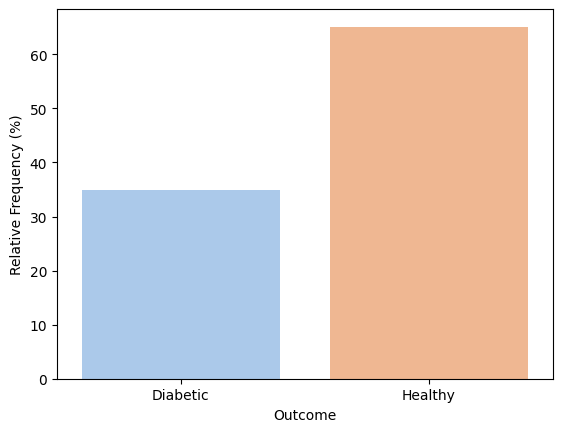

In [3]:
def balanced(df):
  """
    Percentage of passengers with Diabetes and those without Diabetes
    Balanced or Imbalanced Data

    @p:
      df (dataframe): Input dataframe
  """
  df['Outcome'] = np.where(df['Outcome']==0, 'Healthy', 'Diabetic')

  ratio_df=(df[['ID','Outcome']].groupby('Outcome').count()/df.shape[0])*100

  ratio_df.reset_index(inplace=True)

  ratio_df.rename(columns={"ID": "Relative Frequency (%)"}, inplace=True)

  sns.barplot(data=ratio_df, x='Outcome', y="Relative Frequency (%)", palette="pastel")

  plt.savefig("/content/drive/MyDrive/assignments/Spring24/Spec Project/output/balanced.png")

balanced(df)

**PCA**

Based on the loadings the top three important features are Insulin, Glucose, and SkinThickness to predict the likelihood of Diabetes.

It may be beneficial to normalize the data to minimize the influence of any outliers on the analysis.

Reference:

https://www.datacamp.com/tutorial/principal-component-analysis-in-python

https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html

https://stats.stackexchange.com/questions/27300/using-principal-component-analysis-pca-for-feature-selection

In [21]:
pca = PCA(n_components=2)
X=df.to_numpy()
X=X[:,1:-1]
X = pca.fit_transform(X)

In [23]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1','PC2'], index=df.columns[1:-1])
loadings.sort_values(by=['PC1'], ascending=False)

,PC1,PC2
Insulin,0.993111,0.094627
Glucose,0.097812,-0.972210
SkinThickness,0.060757,0.057861
BloodPressure,0.016093,-0.141909
BMI,0.014011,-0.046973
DiabetesPedigreeFunction,0.000537,-0.000817
Pregnancies,-0.002022,-0.022649
Age,-0.003565,-0.140168
